In [1]:
# Import modules
import os
import warnings
warnings.simplefilter("ignore", UserWarning)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.signal as ss
import numpy as np

In [2]:
# Directories and files
DATA_DIR = "../../data/kospi/combined/"  # Using kospi data

In [3]:
# Load Data File List
file_list = os.listdir(DATA_DIR)
codes_list = [f[:-4] for f in file_list]

# 1. Normalized Cross Correlation With Time Shift (At 20 peaks)

In [4]:
def ccf(x, y, lag_max = 100):
    result = ss.correlate(y - np.mean(y), x - np.mean(x), method='direct') / (np.std(y) * np.std(x) * len(y))
    length = (len(result) - 1) // 2
    lo = length - lag_max
    hi = length + (lag_max + 1)

    return result[lo:hi]

In [5]:
ncc_list = []
lag_list = []
company_values = {}
lag = 7
num_peaks = 20
scale_columns = ['volume', 'price', 'ratio']

for file in file_list:
    # Load File
    filepath= DATA_DIR + file
    df = pd.read_csv(filepath)
    
    if df.empty:
        print(file)
        continue
    
    # Scale
    df[scale_columns] -= df[scale_columns].min()
    df[scale_columns] /= df[scale_columns].max()
    df = df.dropna()
    
    # Find Peaks With High "Ratio" Values
    peaks = ss.find_peaks(df['ratio'].values, distance=7)[0]
    top_peaks = df.iloc[peaks,:]
    top_peaks = top_peaks.nlargest(num_peaks, 'ratio')
    # print(top_peaks)
    
    top_timeframes = {}
    # print(top_ten)
    
    # Create Timeframe For Each Peak
    for idx, row in top_peaks.iterrows():
        # print(row)
        start = idx-lag 
        end = idx+lag
        if start < 0 or end > len(df.index):
            continue
        # print("Start: ", start, "End: ", end)
        timeframe = df[start:end]
        top_timeframes[row['period']] = timeframe
        
    # print(top_timeframes)
        
    # Calculate Cross Correlation
    top_ncc = {}
    for peak, timeframe in top_timeframes.items():
        ncc = ccf(timeframe['volume'].values, timeframe['ratio'].values,lag_max=lag)
        max_idx = np.argmax(abs(ncc))
        max_ncc = ncc[max_idx]
        max_lag = max_idx - lag 
        top_ncc[peak] = {
            "ncc": list(ncc),
            "max": [max_ncc, max_lag]
        }
        ncc_list.append(max_ncc)
        lag_list.append(max_lag)
        
    company_values[file[:-4]] = top_ncc
    # print(company_values)
    # print(file, max_ncc, max_lag)
    

C:\Users\bon12\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [6]:
# Find Company With Highest Average Correlation
max_avg = 0
max_company = ""

avg_list = []

for company, peak_info in company_values.items():
    # print(company)
    avg = np.mean([peak_values['max'][0] for peak_time, peak_values in peak_info.items()])
    avg_list.append([company, avg])
    if avg > max_avg:
        max_avg = avg
        max_company = company
        
print(max_company, max_avg)

090080 0.6916901908132947


In [7]:
# Find Top 10 Companies With Highest Average Correlation
sorted_avg_list = sorted(avg_list, key=lambda x:x[1])
print(sorted_avg_list[-10:])

[['004140', 0.5712884537879201], ['118000', 0.5757093457409076], ['129260', 0.5870352156470074], ['004770', 0.5917433614596691], ['267260', 0.5966214892808934], ['003070', 0.6023919913844102], ['003160', 0.6078961965330968], ['241560', 0.6137643369493667], ['013570', 0.6201570451143802], ['007660', 0.6844704921566688]]


C:\Users\bon12\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\bon12\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


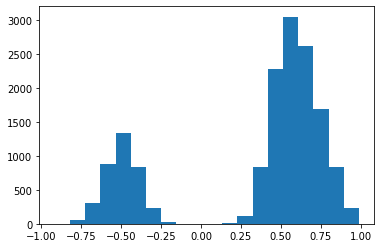

In [8]:
# Draw Histogram
plt.hist(ncc_list, 20)
plt.show()

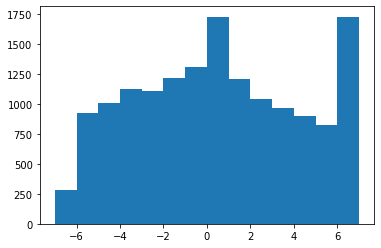

In [9]:
# Draw Histogram
plt.hist(lag_list, 14)
plt.show()

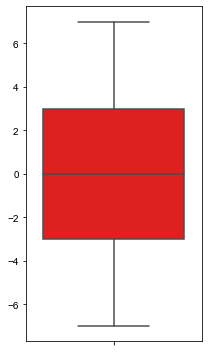

In [10]:
# Draw Boxplot
plt.subplots(1,1, figsize=(3,5))
sns.set_style('whitegrid')
sns.boxplot(lag_list,color='red',orient='v')
plt.tight_layout()

# 2. Look deeper into the company with highest average correlation

In [11]:
# Get all the timeframes for the company

company_values = {}
lag = 7
scale_columns = ['volume', 'price', 'ratio']


filepath= DATA_DIR + "090080.csv"
df = pd.read_csv(filepath)
df[scale_columns] -= df[scale_columns].min()
df[scale_columns] /= df[scale_columns].max()
df = df.dropna()

peaks = ss.find_peaks(df['ratio'].values, distance=7)[0]
top_peaks = df.iloc[peaks,:]
top_peaks = top_peaks.nlargest(20, 'ratio')
# print(top_peaks)


top_timeframes = {}
timeframes_list = []
# Create timeframe for each peak
for idx, row in top_peaks.iterrows():
    # print(row)
    start = idx-lag 
    end = idx+lag
    if start < 0 or end > len(df.index):
        continue
    # print("Start: ", start, "End: ", end)
    timeframe = df[start:end]
    top_timeframes[row['period']] = timeframe
    timeframes_list.append(timeframe)

print(timeframes_list[0])

         period     price    volume     ratio
738  2019-01-09  0.558652  0.166244  0.158344
739  2019-01-10  0.558652  0.060793  0.183881
740  2019-01-11  0.542472  0.023008  0.162612
741  2019-01-14  0.572584  0.020041  0.160336
742  2019-01-15  0.578876  0.030952  0.154218
743  2019-01-16  0.607191  0.063558  0.171006
744  2019-01-17  0.615281  0.099834  0.330630
745  2019-01-18  0.752809  0.538157  1.000000
746  2019-01-21  0.793708  0.133814  0.509105
747  2019-01-22  0.736629  0.063659  0.345711
748  2019-01-23  0.722697  0.036261  0.267179
749  2019-01-24  0.710562  0.030634  0.240361
750  2019-01-25  0.708315  0.049889  0.235951
751  2019-01-28  0.718652  0.068524  0.221511


20


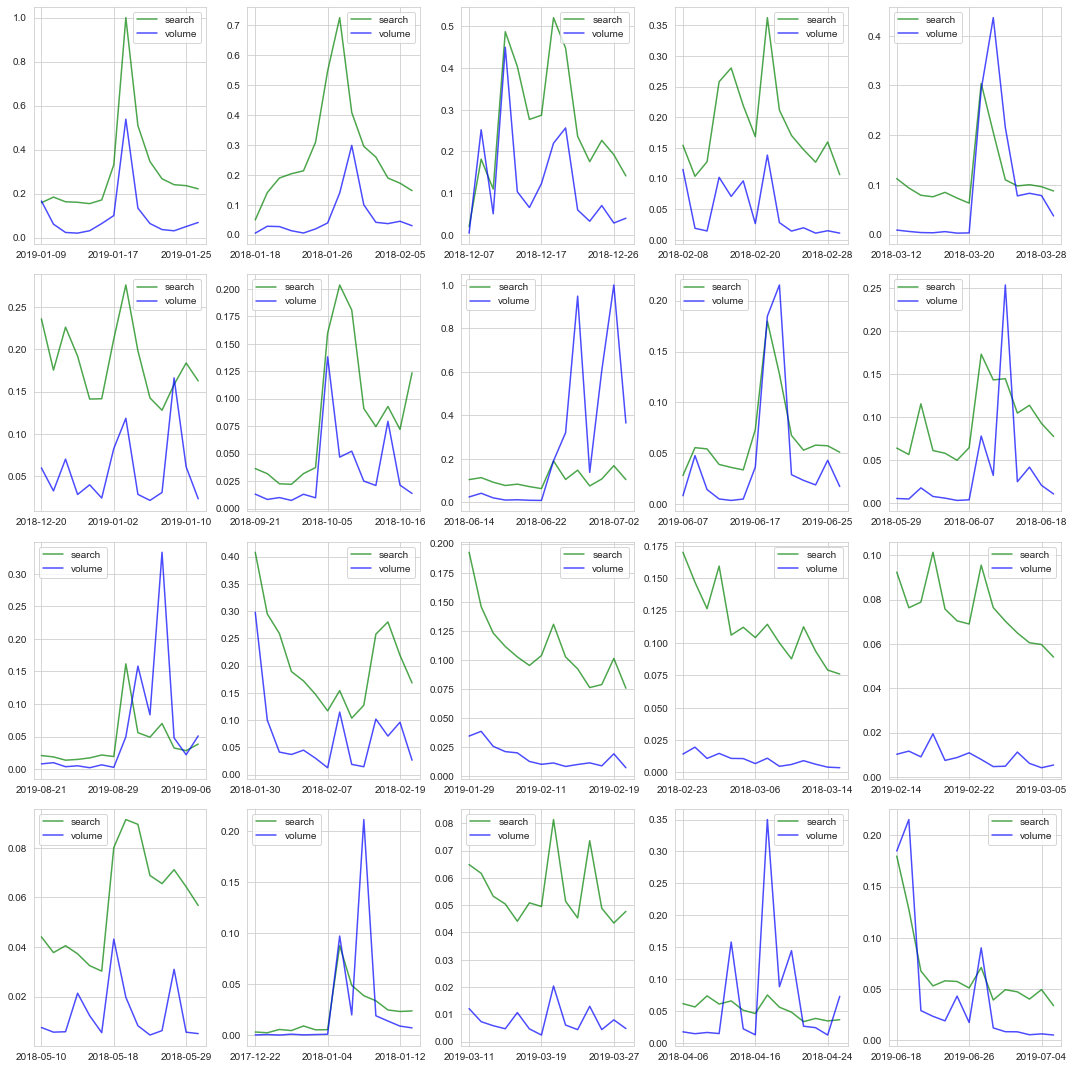

In [12]:
# Plot all the timeframes

fig, ax = plt.subplots(4,5, figsize=(15,15))
fig.tight_layout()
length = len(timeframes_list)
print(length)
for idx, t in enumerate(timeframes_list):
    dates = t['period'].values
    ratio = t['ratio'].values
    volume = t['volume'].values
    row = int(idx/5)
    col = int(idx%5)
    
    ax[row, col].plot(dates, ratio, label="search", color='green', alpha=0.7)
    ax[row, col].plot(dates, volume, label="volume", color='blue', alpha=0.7)
    ax[row, col].set_xticks(dates[::6])
    ax[row, col].set_xticklabels(dates[::6], rotation=0)
    ax[row, col].legend()